In [1]:
import numpy as np
import os
from DH_dynamics import dh_robot_config
from JS_control import *
import matplotlib.pyplot as plt
from pyrep import PyRep
from arm import CtRobot
from pyrep.backend import vrep
import sympy as sp
from pyrep.const import JointMode
import time

%matplotlib notebook

pr = PyRep()

In [2]:
param = ['D', 'a', 'alpha', 'theta', 'num_joints', 'jointType', 'Tbase', 'L', 'M']
config = dict()
for i in range(len(param)):
#     config[param[i]] = np.load('./robot_config/config_ct_7DOF/%s.npy'%param[i])
    config[param[i]] = np.load('./robot_config/inbore_arm/%s.npy'%param[i])

In [3]:
robot = dh_robot_config(int(config['num_joints']), config['alpha'], config['theta'], config['D'], config['a'], 
                                                config['jointType'], config['Tbase'], config['L'], config['M'])
robot.initKinematicTransforms()

Calculating link 0
Calculating link 1
Calculating link 2
Calculating link 3
Calculating link 4
Calculating link 5
Calculating link 6
Calculating link 7
Calculating Mass and Gravity Matrix...
-------------------------------------------------------------------
Calculation complete


## Simulation Set up

### For all joints

In [4]:
pr.launch(os.getcwd() + '/Modified_DH_ct_7DOF.ttt', headless=False)
ct_robot = CtRobot()

xyz = np.array([0, 0, 0])

In [5]:
dt = 0.01
pr.set_simulation_timestep(dt)

In [69]:
# Starting simulation
pr.start()
err_pos = []
err_vel = []
mespos = []
depos = []

# Set up joints to be in force control mode
for i in range(ct_robot._num_joints):
    ct_robot.joints[i].set_joint_mode(JointMode.FORCE)
    ct_robot.joints[i].set_control_loop_enabled(False)
    ct_robot.joints[i].set_motor_locked_at_zero_velocity(True)
for j in range(1, ct_robot._num_joints + 1):
    ct_robot.arms[i].set_dynamic(True)
ct_robot.arms[0].set_dynamic(False)
pr.step()

# Desired trajectory
end_time = 4
t_dic = np.linspace(0, end_time, num=int(end_time/dt), endpoint=True)
t = sp.Symbol('t')
# disired trajectory of position for each joint

# # Sine wave activation
# traj = [
#     0.0*sp.sin(t*4),
#     0.0*sp.cos(t*4),
#     (0/180*np.pi)*sp.sin(t*np.pi),
#     (0/180*np.pi)*sp.sin(t*4),
#     (30/180*np.pi)*sp.cos(t*4),
#     (0/180*np.pi)*sp.cos(t*4),
#     0.00*sp.sin(t/2)
# ]

# Step response
traj = [
    0.01 * sp.ones(1),
    0.01 * sp.ones(1),
    (15/180*np.pi)*sp.ones(1),
    (-30/180*np.pi)*sp.ones(1),
    (45/180*np.pi)*sp.ones(1),
    (20/180*np.pi)*sp.ones(1),
    0.005*sp.ones(1)
]

pos = [sp.lambdify(t, i) for i in traj]
vel = [sp.lambdify(t, i.diff(t)) for i in traj]
acc = [sp.lambdify(t, i.diff(t).diff(t)) for i in traj]

# Gain
# kp = np.diag([10, 10, 200, 2.5, 1, 0.4, 0.4])
# kv = np.diag([0.8, 0.8, 160, 10, 7, 2, 3])

kp = np.eye(7)*10
kv = 2*np.diag(kp)

# Simulation
for i in range(int(end_time/dt)):
    posd = [float(j(t_dic[i])) for j in pos]
    
    veld = np.array([j(t_dic[i]) for j in vel]).squeeze()
    accd = np.array([j(t_dic[i]) for j in acc]).squeeze()
    posm = np.array(ct_robot.get_joint_positions())
    velm = np.array(ct_robot.get_joint_velocities())
    ts1 = time.time()
    tau = cacl_tau(robot, kp, kv, posd, posm, veld, velm, xyz, accd)
    te = time.time()
    print('Time for computing torque: %.6f'%(te-ts1))
    
    ts2 = time.time()
    ct_robot.set_joint_target_velocities((np.sign(tau)*1000000).tolist())
    ct_robot.set_joint_forces(np.abs(tau).tolist())
    pr.step()
    measure_pos = np.array(ct_robot.get_joint_positions())
    measure_vel = np.array(ct_robot.get_joint_velocities())
    te1 = time.time()
    print('Time for communicating with V-REP: %.6f'%(te1-ts2))
    
    # Record error of each joint
    err_pos.append(posd - measure_pos)
    err_vel.append(veld - measure_vel)
    depos.append(posd)
    mespos.append(measure_pos)


Time for computing torque: 0.090220
Time for communicating with V-REP: 0.009532
Time for computing torque: 0.088951
Time for communicating with V-REP: 0.010583
Time for computing torque: 0.089707
Time for communicating with V-REP: 0.012140
Time for computing torque: 0.090386
Time for communicating with V-REP: 0.006193
Time for computing torque: 0.088439
Time for communicating with V-REP: 0.005220
Time for computing torque: 0.093551
Time for communicating with V-REP: 0.005105
Time for computing torque: 0.088047
Time for communicating with V-REP: 0.005131
Time for computing torque: 0.088665
Time for communicating with V-REP: 0.004952
Time for computing torque: 0.089193
Time for communicating with V-REP: 0.005050
Time for computing torque: 0.089365
Time for communicating with V-REP: 0.004988
Time for computing torque: 0.085737
Time for communicating with V-REP: 0.005006
Time for computing torque: 0.091790
Time for communicating with V-REP: 0.004997
Time for computing torque: 0.088906
Time

Time for computing torque: 0.091845
Time for communicating with V-REP: 0.005870
Time for computing torque: 0.089632
Time for communicating with V-REP: 0.006102
Time for computing torque: 0.089363
Time for communicating with V-REP: 0.006186
Time for computing torque: 0.093006
Time for communicating with V-REP: 0.004913
Time for computing torque: 0.089368
Time for communicating with V-REP: 0.004885
Time for computing torque: 0.087514
Time for communicating with V-REP: 0.006030
Time for computing torque: 0.091985
Time for communicating with V-REP: 0.006185
Time for computing torque: 0.090816
Time for communicating with V-REP: 0.004961
Time for computing torque: 0.090729
Time for communicating with V-REP: 0.004993
Time for computing torque: 0.089836
Time for communicating with V-REP: 0.006061
Time for computing torque: 0.090234
Time for communicating with V-REP: 0.005069
Time for computing torque: 0.087708
Time for communicating with V-REP: 0.004989
Time for computing torque: 0.091654
Time

Time for computing torque: 0.092336
Time for communicating with V-REP: 0.004933
Time for computing torque: 0.095350
Time for communicating with V-REP: 0.006251
Time for computing torque: 0.092804
Time for communicating with V-REP: 0.004923
Time for computing torque: 0.094898
Time for communicating with V-REP: 0.005975
Time for computing torque: 0.089924
Time for communicating with V-REP: 0.004946
Time for computing torque: 0.093632
Time for communicating with V-REP: 0.005177
Time for computing torque: 0.093936
Time for communicating with V-REP: 0.004963
Time for computing torque: 0.094403
Time for communicating with V-REP: 0.005265
Time for computing torque: 0.094126
Time for communicating with V-REP: 0.005010
Time for computing torque: 0.091030
Time for communicating with V-REP: 0.005146
Time for computing torque: 0.093466
Time for communicating with V-REP: 0.004928
Time for computing torque: 0.091243
Time for communicating with V-REP: 0.005092
Time for computing torque: 0.090376
Time

Time for communicating with V-REP: 0.006093
Time for computing torque: 0.092543
Time for communicating with V-REP: 0.006180
Time for computing torque: 0.094106
Time for communicating with V-REP: 0.005107
Time for computing torque: 0.091831
Time for communicating with V-REP: 0.004882
Time for computing torque: 0.087502
Time for communicating with V-REP: 0.004815
Time for computing torque: 0.090385
Time for communicating with V-REP: 0.005032
Time for computing torque: 0.092212
Time for communicating with V-REP: 0.004932
Time for computing torque: 0.092054
Time for communicating with V-REP: 0.005829
Time for computing torque: 0.088324
Time for communicating with V-REP: 0.005258
Time for computing torque: 0.093223
Time for communicating with V-REP: 0.006268
Time for computing torque: 0.101631
Time for communicating with V-REP: 0.005229
Time for computing torque: 0.091886
Time for communicating with V-REP: 0.006578
Time for computing torque: 0.094981
Time for communicating with V-REP: 0.006

In [66]:
# Change Unit
err_pos = np.array(err_pos)
mespos = np.array(mespos)
depos = np.array(depos)

for name in ['err_pos', 'mespos', 'depos']:
    x = eval(name)
    x[:, 0:1] = x[:, 0:1]*1000
    x[:, 1:2] = x[:, 1:2]*1000
    x[:, 6:7] = x[:, 6:7]*1000
    x[:, 2:3] = x[:, 2:3]*180/np.pi
    x[:, 3:4] = x[:, 3:4]*180/np.pi
    x[:, 4:5] = x[:, 4:5]*180/np.pi
    x[:, 5:6] = x[:, 5:6]*180/np.pi

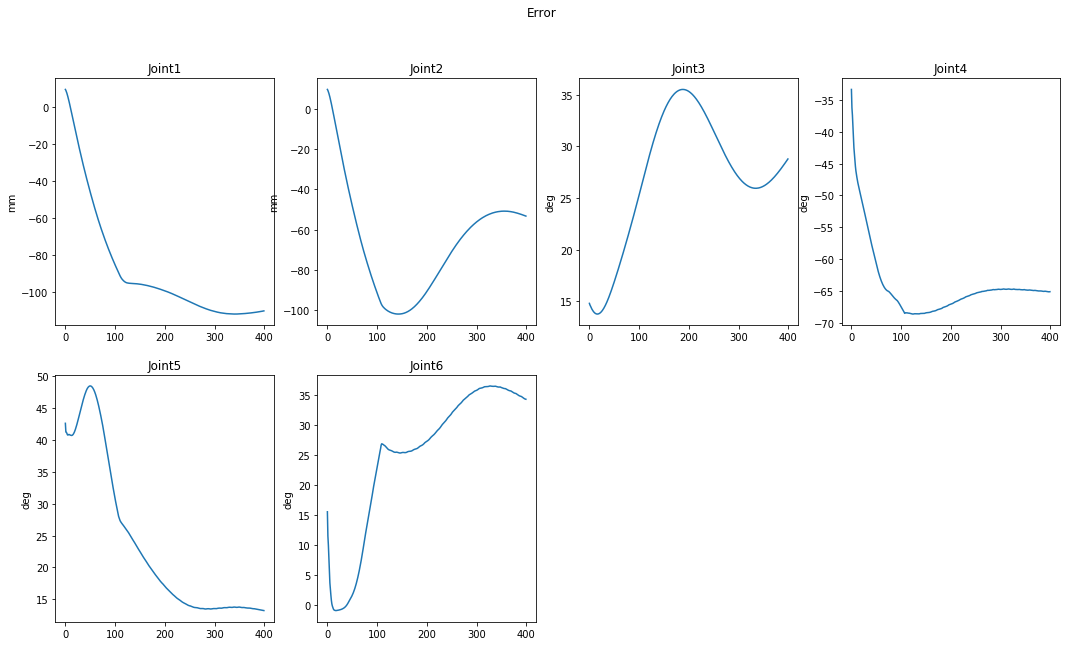

In [67]:
# Plot error of position from joint to joint
plt.figure(figsize=(18,10))
plt.suptitle('Error')
for i in range(6):
    plt.subplot(2,4,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(np.array(err_pos)[:, i])
    if i in [0,1,6]:
        plt.ylabel('mm')
    else:
        plt.ylabel('deg')

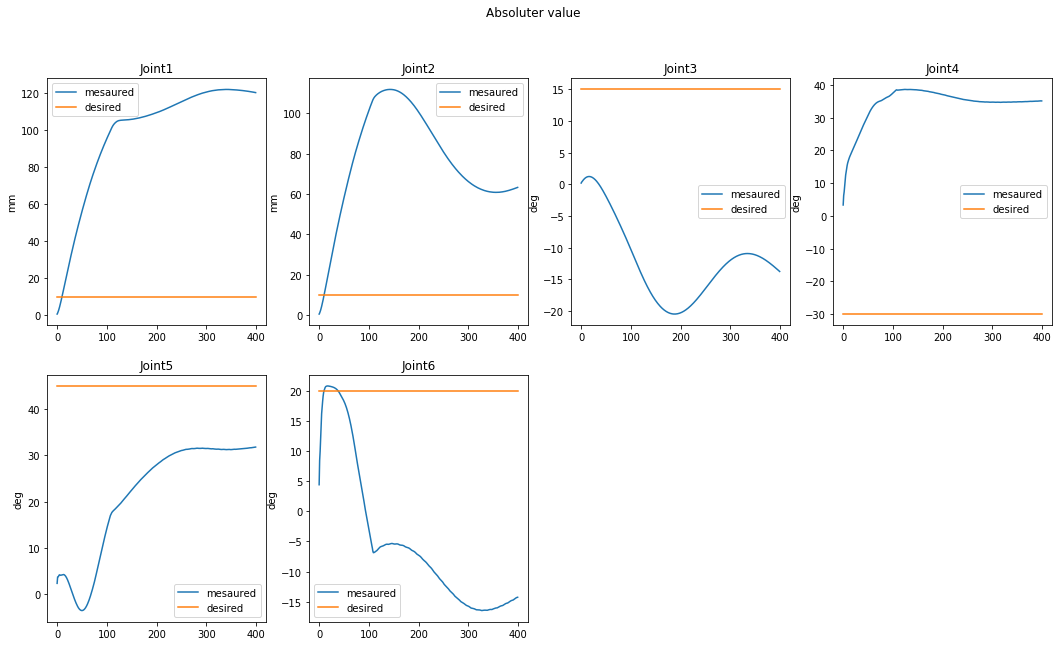

In [68]:
# Plot error of position from joint to joint
plt.figure(figsize=(18,10))
plt.suptitle('Absoluter value')
for i in range(6):
    plt.subplot(2,4,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(mespos[:, i], label='mesaured')
    plt.plot(depos[:, i], label='desired')
    plt.legend()
    if i in [0,1,6]:
        plt.ylabel('mm')
    else:
        plt.ylabel('deg')


In [70]:
pr.stop()

In [71]:
pr.shutdown()